In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Read the CSV file
df = pd.read_csv('diagnosed_cbc_data_v4.csv')

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


In [3]:
# Data Analysis

# 1. Identify unique diagnoses and their counts
diagnosis_counts = df['Diagnosis'].value_counts()
print("\nDiagnosis counts:")
diagnosis_counts


Diagnosis counts:


Diagnosis
Healthy                           336
Normocytic hypochromic anemia     279
Normocytic normochromic anemia    269
Iron deficiency anemia            189
Thrombocytopenia                   73
Other microcytic anemia            59
Leukemia                           47
Macrocytic anemia                  18
Leukemia with thrombocytopenia     11
Name: count, dtype: int64

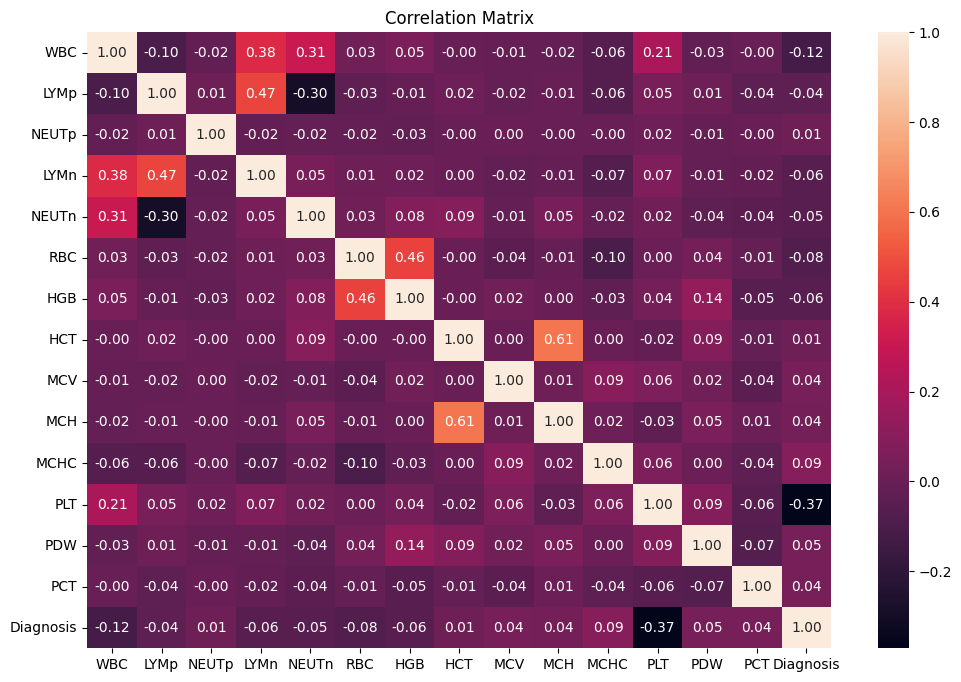

In [4]:
# 2. Analyze correlation between parameters and diagnosis
# Encode the 'Diagnosis' column to numeric values for correlation analysis
df_encoded = df.copy()
df_encoded['Diagnosis'] = df_encoded['Diagnosis'].astype('category').cat.codes
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Data Preprocessing
# Encode categorical Diagnosis column
df['Diagnosis'] = df['Diagnosis'].astype('category').cat.codes

In [6]:
# Split the data into features and target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

In [7]:
# Split the data into 80% training and 20% validation
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Handle class imbalance by oversampling the training set
df_train_full = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train_full['Diagnosis'].value_counts().max()

In [9]:
# Resample each class to match the size of the largest class
lst = [df_train_full]
for class_index, group in df_train_full.groupby('Diagnosis'):
    lst.append(group.sample(max_size-len(group), replace=True))
df_balanced = pd.concat(lst)

X_balanced = df_balanced.drop('Diagnosis', axis=1)
y_balanced = df_balanced['Diagnosis']

In [10]:
# Standardize the balanced features
scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)
X_val_scaled = scaler.transform(X_val)

In [11]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)  # Number of components
X_balanced_pca = pca.fit_transform(X_balanced_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [12]:
# Convert target to tensor
y_balanced_tensor = torch.tensor(y_balanced.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

In [13]:
# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
all_y_test = []
all_y_pred = []

class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

for train_index, test_index in kfold.split(X_balanced_pca):
    X_train, X_test = X_balanced_pca[train_index], X_balanced_pca[test_index]
    y_train, y_test = y_balanced_tensor[train_index], y_balanced_tensor[test_index]

    # Create datasets and dataloaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train)
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Build the Neural Network model
    model = SimpleNN(input_dim=X_train.shape[1], output_dim=len(y_balanced.unique()))
    
    # Compile the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in range(50):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            all_preds.extend(predicted.numpy())
            all_targets.extend(y_batch.numpy())

    accuracy = correct / total
    accuracy_scores.append(accuracy)
    all_y_test.extend(all_targets)
    all_y_pred.extend(all_preds)

In [14]:
# Overall performance
print("\nK-Fold Cross-Validation Accuracy Scores:")
print(accuracy_scores)
print("\nMean Accuracy: ", np.mean(accuracy_scores))


K-Fold Cross-Validation Accuracy Scores:
[0.9567010309278351, 0.9235537190082644, 0.8657024793388429, 0.9008264462809917, 0.9276859504132231]

Mean Accuracy:  0.9148939251938314


In [15]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_y_test, all_y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       269
           1       0.88      0.95      0.91       269
           2       0.92      0.99      0.95       269
           3       0.94      1.00      0.97       269
           4       0.96      1.00      0.98       269
           5       0.89      0.73      0.80       269
           6       0.91      0.88      0.89       269
           7       0.89      0.91      0.90       269
           8       0.89      0.94      0.92       269

    accuracy                           0.91      2421
   macro avg       0.92      0.91      0.91      2421
weighted avg       0.92      0.91      0.91      2421



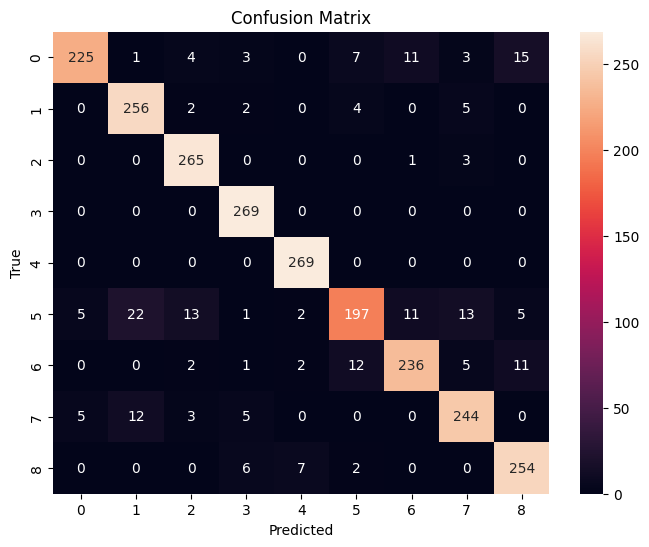

In [16]:
# Confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Evaluate the model on the validation set
validation_dataset = TensorDataset(torch.tensor(X_val_pca, dtype=torch.float32), y_val_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

model.train()
for epoch in range(50):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

model.eval()
all_preds_val = []
all_targets_val = []

with torch.no_grad():
    for X_batch, y_batch in validation_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds_val.extend(predicted.numpy())
        all_targets_val.extend(y_batch.numpy())

In [18]:
# Validation performance
print("\nValidation Set Accuracy: ", np.mean(np.array(all_preds_val) == np.array(all_targets_val)))
print("\nValidation Set Classification Report:")
print(classification_report(all_targets_val, all_preds_val))


Validation Set Accuracy:  0.867704280155642

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        67
           1       0.94      0.89      0.92        38
           2       0.50      0.44      0.47         9
           3       0.67      1.00      0.80         2
           4       0.60      0.75      0.67         4
           5       0.86      0.86      0.86        56
           6       0.98      0.98      0.98        54
           7       0.60      0.75      0.67        12
           8       0.70      0.93      0.80        15

    accuracy                           0.87       257
   macro avg       0.75      0.83      0.78       257
weighted avg       0.88      0.87      0.87       257



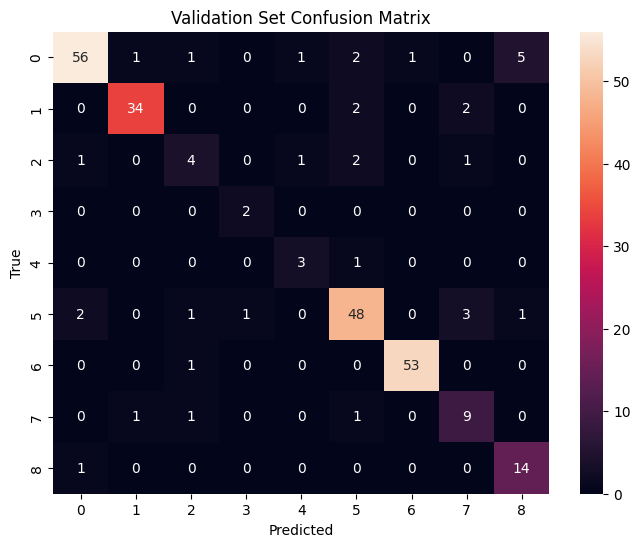

In [19]:
# Validation set confusion matrix
conf_matrix_val = confusion_matrix(all_targets_val, all_preds_val)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d')
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()